


# **Loading and Previewing Dataset from Google Sheets**




In [3]:
import pandas as pd

sheet_url = "https://docs.google.com/spreadsheets/d/1Bj4-sd6362GWrFZOPcND3fFo0oroO1pfhkpMJh8iIE4/export?format=csv"
data = pd.read_csv(sheet_url)

print("Dataset Preview:")
print(data.head())

print("\nDataset Info:")
print(data.info())


Dataset Preview:
   Performance                                          Video URL
0       1.1060  https://fgimagestorage.blob.core.windows.net/f...
1       2.2447  https://fgimagestorage.blob.core.windows.net/f...
2       2.0126  https://fgimagestorage.blob.core.windows.net/f...
3       1.7708  https://fgimagestorage.blob.core.windows.net/f...
4       0.6293  https://fgimagestorage.blob.core.windows.net/f...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Performance  268 non-null    float64
 1   Video URL    268 non-null    object 
dtypes: float64(1), object(1)
memory usage: 4.3+ KB
None


# **Processing and Analyzing Video Data for Duplicates and Performance**

### This code downloads videos from URLs, computes hashes of their first frames to **identify unique videos**, and aggregates performance data for duplicates. It **calculates the average performance** for each unique video and saves the **results to a CSV file** for further analysis.

In [4]:
import cv2
import hashlib
import os
import requests

# Helper function to download a video from a URL
def download_video(video_url, save_path):
    try:
        response = requests.get(video_url, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            return True
        else:
            print(f"Failed to download video: {video_url}")
            return False
    except Exception as e:
        print(f"Error downloading video: {e}")
        return False

# Helper function to compute hash of the first frame of a video
def compute_video_hash(video_path):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    cap.release()
    if not success:
        print(f"Error reading video: {video_path}")
        return None
    # Compute a hash of the first frame
    frame_hash = hashlib.md5(frame).hexdigest()
    return frame_hash

# Directory to store downloaded videos
os.makedirs("videos", exist_ok=True)

# Dataset column containing video URLs and performance scores
video_urls = data['Video URL']
video_performance = data['Performance']


# Dictionaries to track unique videos and performance data
video_hashes = {}  # Track which hash belongs to which video
performance_data = {}  # Store performance details for unique videos

# Process each video URL
for idx, video_url in enumerate(video_urls):
    print(f"Processing video {idx + 1}/{len(video_urls)}: {video_url}")

    # Download the video
    video_path = f"videos/video_{idx}.mp4"
    if not os.path.exists(video_path):  # Skip downloading if already exists
        if not download_video(video_url, video_path):
            continue

    # Compute hash of the first frame
    video_hash = compute_video_hash(video_path)
    if video_hash is None:
        continue

    # Check for duplicates
    if video_hash in video_hashes:
        print(f"Duplicate found: {video_path} matches {video_hashes[video_hash]}")
        # Aggregate performance data for duplicates
        performance_data[video_hash]['total_performance'] += video_performance[idx]
        performance_data[video_hash]['count'] += 1
    else:
        print(f"Unique video: {video_path}")
        video_hashes[video_hash] = video_path
        performance_data[video_hash] = {
            'video_url': video_url,
            'total_performance': video_performance[idx],
            'count': 1
        }

# Calculate average performance for each unique video
result = []
for video_hash, data in performance_data.items():
    avg_performance = data['total_performance'] / data['count']
    result.append({
        'Video URL': data['video_url'],
        'Average Performance': avg_performance,
        'Count': data['count']
    })

# Convert result to a DataFrame for better representation
result_df = pd.DataFrame(result)

# Print the result
print("\nUnique Videos with Average Performance:")
print(result_df)

# Save result to a CSV file for further use
result_df.to_csv("unique_videos_performance.csv", index=False)
print("\nResults saved to 'unique_videos_performance.csv'")



Processing video 1/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-999607261342550
Unique video: videos/video_0.mp4
Processing video 2/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-997580728807604
Unique video: videos/video_1.mp4
Processing video 3/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992418235673669
Unique video: videos/video_2.mp4
Processing video 4/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992064161877405
Unique video: videos/video_3.mp4
Processing video 5/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-991636695150147
Duplicate found: videos/video_4.mp4 matches videos/video_0.mp4
Processing video 6/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989969399547901
Unique video: videos/video_5.mp4
Processing video 7/268: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989930303148492
Unique video: videos/video_6.mp4
Processing 

# **Insight into the Processed File: Identifying Unique and Duplicate Videos**

### This code calculates the total number of unique videos and the count of duplicate videos processed, and appends this summary to the results CSV file for further analysis.

In [5]:
# Calculate total counts
total_unique_videos = len(result_df)
total_duplicate_videos = sum(result_df['Count']) - total_unique_videos

# Add summary information to the CSV
summary = {
    'Metric': ['Total Unique Videos', 'Total Duplicate Videos Processed'],
    'Value': [total_unique_videos, total_duplicate_videos]
}
summary_df = pd.DataFrame(summary)

# Append the summary to the results CSV file
with open("unique_videos_performance.csv", 'a') as f:
    f.write("\n")
    summary_df.to_csv(f, index=False)

print("\nSummary added to 'unique_videos_performance.csv':")
print(summary_df)



Summary added to 'unique_videos_performance.csv':
                             Metric  Value
0               Total Unique Videos     74
1  Total Duplicate Videos Processed    194


# **Face Detection in Videos: Extracting Influencers' Faces**

### This code processes each unique video to detect faces using a pre-trained Haar Cascade model. If a face is detected, the corresponding frame is saved as an image, and the path to the saved image is added to the DataFrame. The updated DataFrame with face image paths is then saved to a CSV file for further analysis.

In [6]:
# Load pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Directory to store frames with detected faces
os.makedirs("faces", exist_ok=True)

# Placeholder for the influencers_faces column
influencers_faces = []

# Process each unique video
for idx, row in result_df.iterrows():
    video_path = row['Video URL']
    print(f"Processing video {idx + 1}/{len(result_df)}: {video_path}")

    # Capture video
    cap = cv2.VideoCapture(video_path)
    face_detected = False
    frame_path = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Convert frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) > 0:
            # Save the frame with the detected face
            frame_path = f"faces/face_{idx}.jpg"
            cv2.imwrite(frame_path, frame)
            face_detected = True
            break

    cap.release()

    if face_detected:
        print(f"Face detected and saved: {frame_path}")
    else:
        print(f"No face detected in video: {video_path}")
        frame_path = None  # No face detected

    # Append the path or None to the column
    influencers_faces.append(frame_path)

# Update the DataFrame
result_df['Influencers Faces'] = influencers_faces

# Save the updated DataFrame
result_df.to_csv("unique_videos_with_faces.csv", index=False)
print("\nResults saved to 'unique_videos_with_faces.csv'")


Processing video 1/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-999607261342550
Face detected and saved: faces/face_0.jpg
Processing video 2/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-997580728807604
Face detected and saved: faces/face_1.jpg
Processing video 3/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992418235673669
Face detected and saved: faces/face_2.jpg
Processing video 4/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-992064161877405
Face detected and saved: faces/face_3.jpg
Processing video 5/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989969399547901
Face detected and saved: faces/face_4.jpg
Processing video 6/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989930303148492
Face detected and saved: faces/face_5.jpg
Processing video 7/74: https://fgimagestorage.blob.core.windows.net/facebook-assets/hd-989654009083459
Face detected and saved: fa

# **Displaying Extracted Faces from Videos**

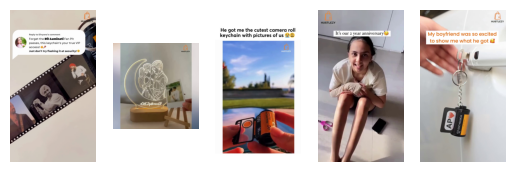

In [7]:
import matplotlib.pyplot as plt

# Load the first 5 images from the 'Influencers Faces' column
for idx, face_path in enumerate(result_df['Influencers Faces'][:5]):
    if face_path is not None:
        # Read the image
        face_image = cv2.imread(face_path)

        # Convert the image from BGR to RGB (OpenCV uses BGR by default)
        face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

        # Display the image using matplotlib
        plt.subplot(1, 5, idx + 1)
        plt.imshow(face_image_rgb)
        plt.axis('off')  # Hide axes

plt.show()

In [9]:
print(result_df)

                                            Video URL  Average Performance  \
0   https://fgimagestorage.blob.core.windows.net/f...             1.148805   
1   https://fgimagestorage.blob.core.windows.net/f...             1.017379   
2   https://fgimagestorage.blob.core.windows.net/f...             2.012600   
3   https://fgimagestorage.blob.core.windows.net/f...             0.910115   
4   https://fgimagestorage.blob.core.windows.net/f...             1.047049   
..                                                ...                  ...   
69  https://fgimagestorage.blob.core.windows.net/f...             0.039172   
70  https://fgimagestorage.blob.core.windows.net/f...             1.438421   
71  https://fgimagestorage.blob.core.windows.net/f...             0.904685   
72  https://fgimagestorage.blob.core.windows.net/f...             1.270688   
73  https://fgimagestorage.blob.core.windows.net/f...             1.604623   

    Count  Influencers Faces  
0      88   faces/face_0.jpg  
1

# **Visualizing Top Influencers Based on Performance**

 This code provides two main visualizations:

1.  Barplot of Top 10 Influencers by Average Performance:

*   The dataset is sorted by 'Average Performance' to identify the top 10
influencers.
*  A bar plot is displayed with the influencers' faces and their corresponding average performance scores.



 2.  Display of Top 5 Influencers by Performance:

 *   The first 5 influencers are selected based on their average performance.
 *  Their images are displayed in a grid, with each face shown alongside its corresponding performance score for easy comparison.


<ipython-input-17-713b75bd126c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df_sorted.head(10), x='Average Performance', y='Influencers Faces', palette='coolwarm')


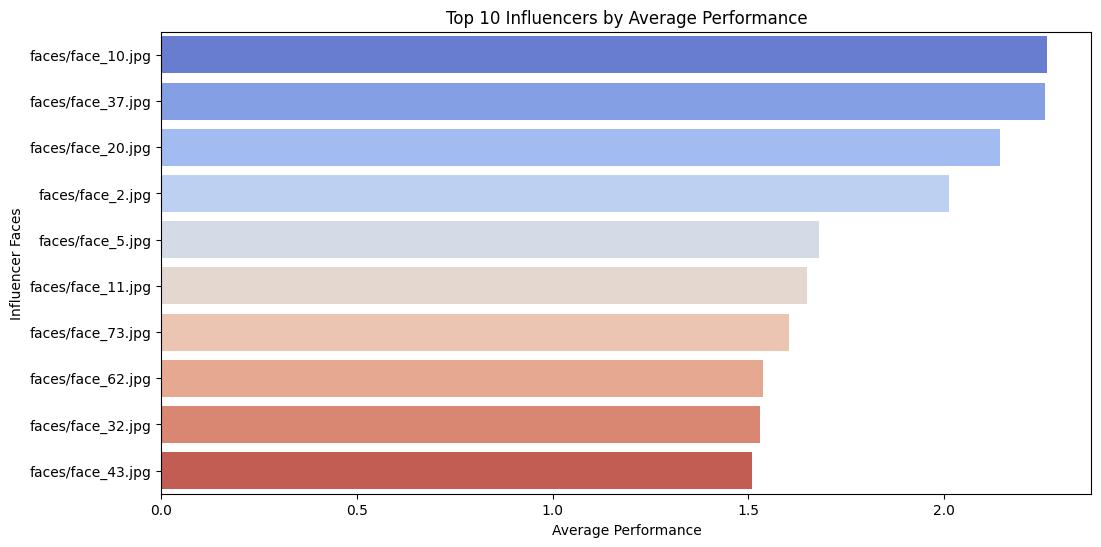

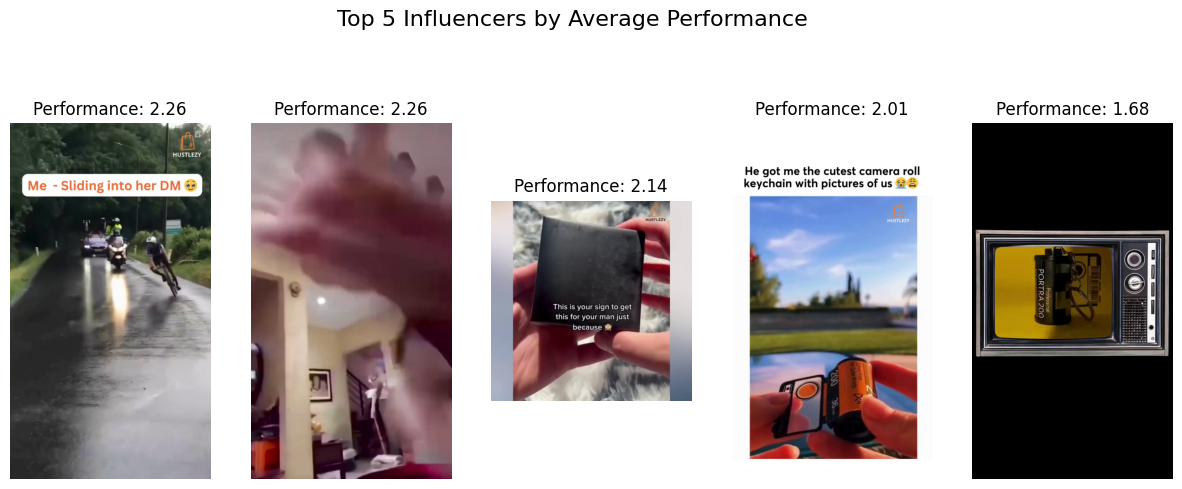

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import matplotlib.pyplot as plt

# Assuming 'result_df' is your DataFrame

# 1. Sort the dataset by Average Performance to identify top influencers
result_df_sorted = result_df.sort_values(by='Average Performance', ascending=False)

# 2. Plot the Average Performance of Influencers (Top 10)
plt.figure(figsize=(12, 6))
sns.barplot(data=result_df_sorted.head(10), x='Average Performance', y='Influencers Faces', palette='coolwarm')
plt.title('Top 10 Influencers by Average Performance')
plt.xlabel('Average Performance')
plt.ylabel('Influencer Faces')
plt.show()

# 3. Display Images of the Top 5 Influencers by Performance
plt.figure(figsize=(15, 6))

# Limit to first 5 influencers
top_5_influencers = result_df_sorted.head(5)

# Iterate over the first 5 rows in the sorted DataFrame
for idx, (row_index, row) in enumerate(top_5_influencers.iterrows()):
    face_path = row['Influencers Faces']
    if face_path:
        face_image = cv2.imread(face_path)
        face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, idx + 1)  # Ensure idx + 1 correctly fits into the subplot grid
        plt.imshow(face_image_rgb)
        plt.title(f"Performance: {row['Average Performance']:.2f}")
        plt.axis('off')  # Hide axes for better visualization

plt.suptitle('Top 5 Influencers by Average Performance', fontsize=16)
plt.show()

# **Displaying Influencer Faces and Their Performance**

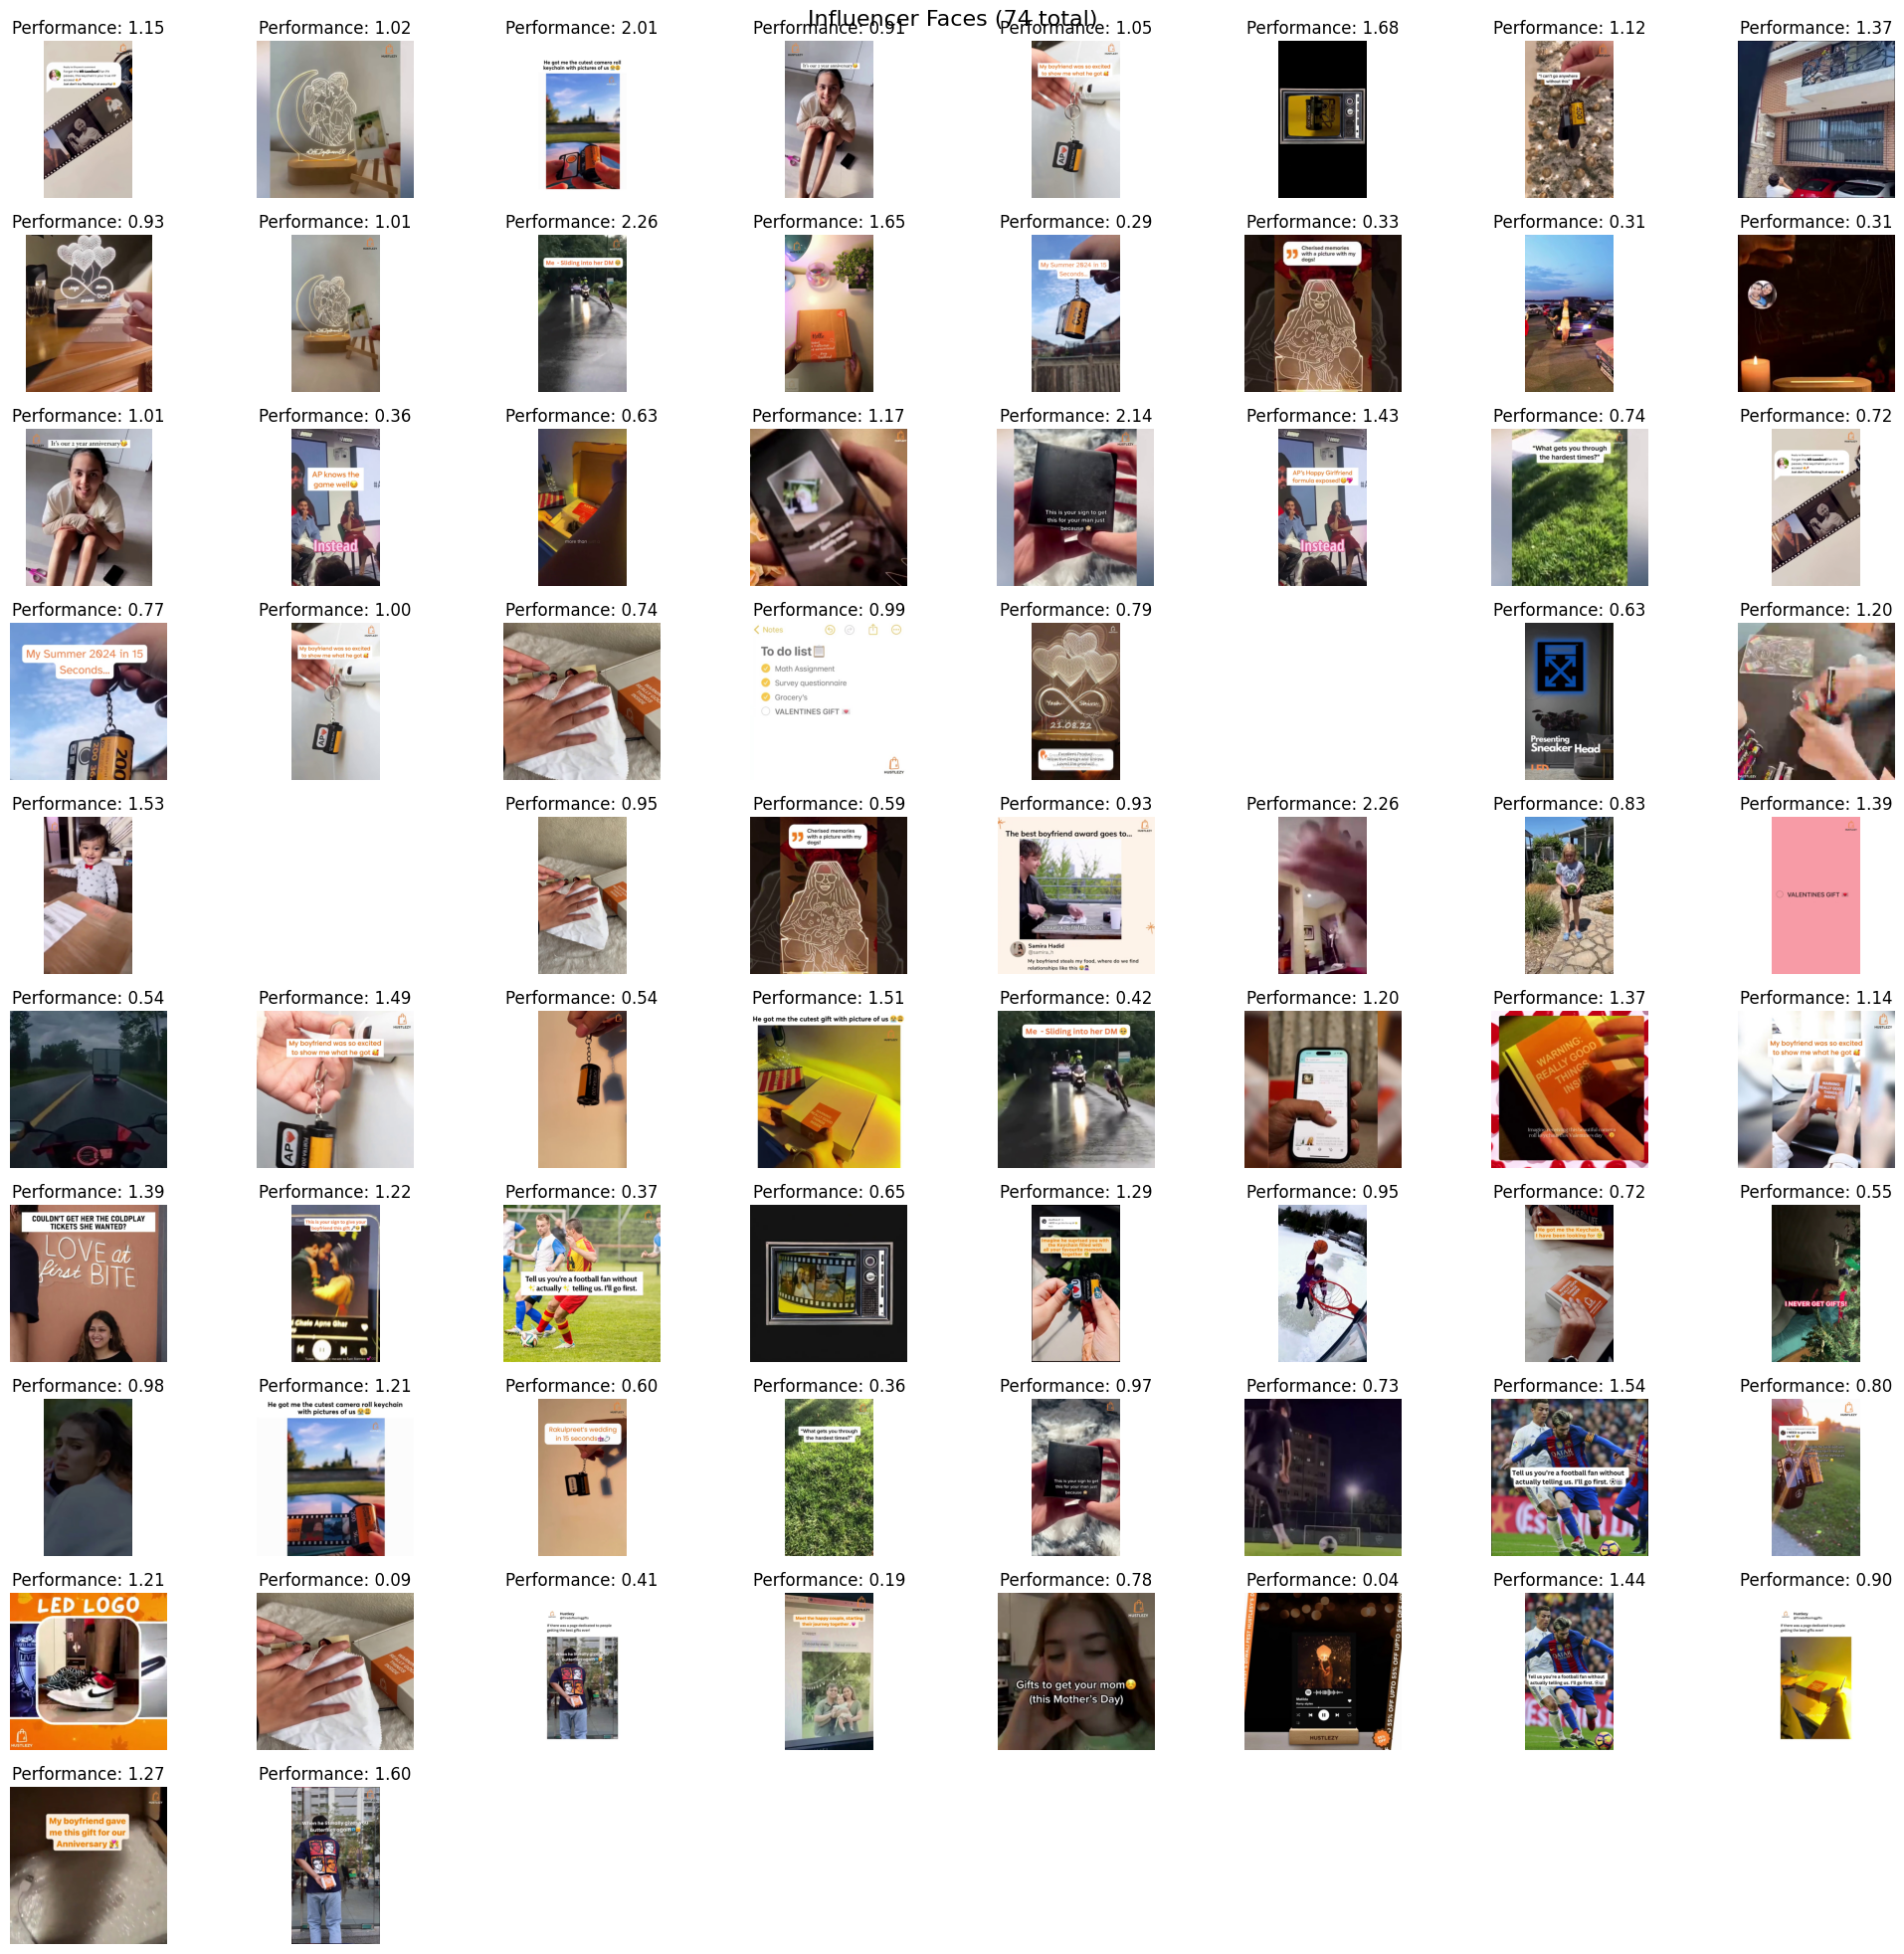

In [19]:
rows = 10
cols = 8

# Create a new figure for displaying the images
plt.figure(figsize=(20, 20))

# Loop through all rows in result_df
for idx, row in result_df.iterrows():
    face_path = row['Influencers Faces']

    if face_path:  # Ensure the path exists
        face_image = cv2.imread(face_path)  # Read the image
        face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        # Position each image on the grid (with a 1-based index)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(face_image_rgb)
        plt.title(f"Performance: {row['Average Performance']:.2f}")  # Title with performance score
        plt.axis('off')  # Hide axes for better visualization

# Show the images
plt.suptitle('Influencer Faces (74 total)', fontsize=16)
plt.tight_layout()
plt.show()


## **Download the Processed CSV File**

In [20]:
from google.colab import files

# Save the DataFrame to a CSV file
result_df.to_csv('result.csv', index=False)

# Download the file
files.download('result.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>